In [10]:
!pip install pyxdf
!pip install mne
!pip install pandas
!pip install --upgrade jupyterlab ipympl ipywidgets


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [11]:
WORDLIST = [
    'კავშირი',  # Facebook
    'მეგობრები',
    'საზოგადოება',
    'ჯგუფი',
    'პოსტი',
    'რეაქცია',
    'პროფილი',
    'მესიჯი',
    'ღონისძიება',
    'ნოსტალგია',
    'კონტენტი',  # YouTube
    'ჩენელი',
    'ქრიეთორი',
    'ტუტორიალი',
    'ვიდეო',
    'ჩელენჯი',
    'კომენტარები',
    'სტრიმი',
    'სწავლა',
    'ალგორითმი',
    'გართობა',  # Shared
    'ამბები',
    'დრო',
    'რეალობა',
    'ტყუილი',
    'ინგეიჯმენთი',
    'ფული',
    'თვალთვალი',
    'პოლიტიკა',
    'ავთენტურობა',
    'პეპელა',  # Unrelated
    'მთები',
    'სანთელი',
    'ოკეანე',
    'აგური',
    'ბალიში',
    'ვიოლინო',
    'ცისარტყელა',
    'წიგნი',
    'ბურთი'
]

In [12]:
facebook_wordlist = WORDLIST[0:10]
youtube_wordlist = WORDLIST[10:20]
shared_wordlist = WORDLIST[20:30]
unrelated_wordlist = WORDLIST[30:40]

In [13]:
import sys
print(sys.version)

3.11.13 (main, Sep 22 2025, 18:50:24) [Clang 17.0.0 (clang-1700.0.13.5)]


In [14]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mne
import pandas as pd
import os

In [15]:
csv_data = pd.read_csv('data/avto_brand.csv')
# csv_data = pd.read_csv('data/nani_n400.csv')
csv_data.head()

,timestamp_iso,trial_index,brand,brand_path,target,prime_time_s,isi_s,target_time_s,cooldown_s,resp_window_s,resp_key,rt_ms_from_target,rt_ms_from_window_open
0,2025-10-31T08:50:04.604,0,facebook,C:\Users\Nadira\Documents\Experiments\visual-e...,გართობა,0.16,0.7,0.16,0.0,1.0,right,791.63,791.63
1,2025-10-31T08:50:06.835,1,youtube,C:\Users\Nadira\Documents\Experiments\visual-e...,ჯგუფი,0.16,0.7,0.16,0.0,1.0,left,885.34,885.34
2,2025-10-31T08:50:09.050,2,youtube,C:\Users\Nadira\Documents\Experiments\visual-e...,ავთენტურობა,0.16,0.7,0.16,0.0,1.0,NaN,NaN,NaN
3,2025-10-31T08:50:11.264,3,youtube,C:\Users\Nadira\Documents\Experiments\visual-e...,კომენტარები,0.16,0.7,0.16,0.0,1.0,right,908.67,908.67
4,2025-10-31T08:50:13.463,4,youtube,C:\Users\Nadira\Documents\Experiments\visual-e...,დრო,0.16,0.7,0.16,0.0,1.0,right,759.71,759.71


In [16]:
facebook_idx = csv_data[csv_data['brand'] == 'facebook'].index.values
youtube_idx = csv_data[csv_data['brand'] == 'youtube'].index.values

In [17]:
facebook_words_idx = csv_data[csv_data['target'].isin(facebook_wordlist)].index.values
youtube_words_idx = csv_data[csv_data['target'].isin(youtube_wordlist)].index.values
shared_words_idx = csv_data[csv_data['target'].isin(shared_wordlist)].index.values
unrelated_words_idx = csv_data[csv_data['target'].isin(unrelated_wordlist)].index.values

In [159]:
response_idx = csv_data[~csv_data['resp_key'].isna()].index.values
len(response_idx)

353

In [19]:
xdf_path = './data/avto_brand.xdf'
xdf_data = pyxdf.load_xdf(xdf_path)[0]
markers = xdf_data[0]
eeg = xdf_data[1]

In [20]:
# Redefine for Luka's data
# xdf_path = './data/luka_n400.xdf'
# xdf_data = pyxdf.load_xdf(xdf_path)[0]
# markers = xdf_data[0]
# eeg = xdf_data[1]

In [21]:
# Read marker data
marker_time = markers['time_stamps']
time_offset = marker_time[0]
marker_time = marker_time - time_offset
marker_data = [x[0] for x in markers['time_series']]

In [22]:
# n400_data = ExperimentData('data/nani_n400.xdf')

In [23]:
CONST_OFFSET = 0.073  # Delay measured with photodiode that day

In [24]:
eeg_time = eeg['time_stamps']
eeg_time = eeg_time - time_offset - CONST_OFFSET
eeg_data = eeg['time_series'][:, :8]

In [25]:
# Create raw data
info = mne.create_info(ch_names=['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8'], ch_types=['eeg'] * 8,
                       sfreq=250)
raw = mne.io.RawArray([1e-6 * eeg_data[:, i] for i in range(8)], info)
raw.notch_filter(freqs=[50])
raw.filter(0.5, 30)
raw

Creating RawArray with float64 data, n_channels=8, n_times=249454
    Range : 0 ... 249453 =      0.000 ...   997.812 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband a

<RawArray | 8 x 249454 (997.8 s), ~15.2 MiB, data loaded>

In [26]:
TARGET_MARKER = 1
RESPONSE_MARKER = 2

In [27]:
events = []
for i, marker in enumerate(marker_data):
    eeg_start_index = np.argmax(eeg_time >= marker_time[i]) - 1
    events.append([eeg_start_index, 0, marker])
events = np.array(events)

In [176]:
picks = ["Cz", "Pz"]
event_dict = dict(target=1)
tmin, tmax = -0.2, 1.01
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=tmin, tmax=tmax, preload=True,
                    baseline=(None, 0 if tmin < 0 else None), picks=picks)

Not setting metadata
401 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 401 events and 303 original time points ...
0 bad epochs dropped


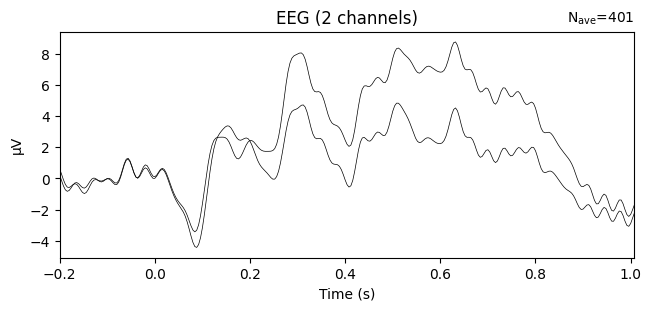

In [29]:
epochs.average().plot(picks=picks)
plt.show()

combining channels using "mean"


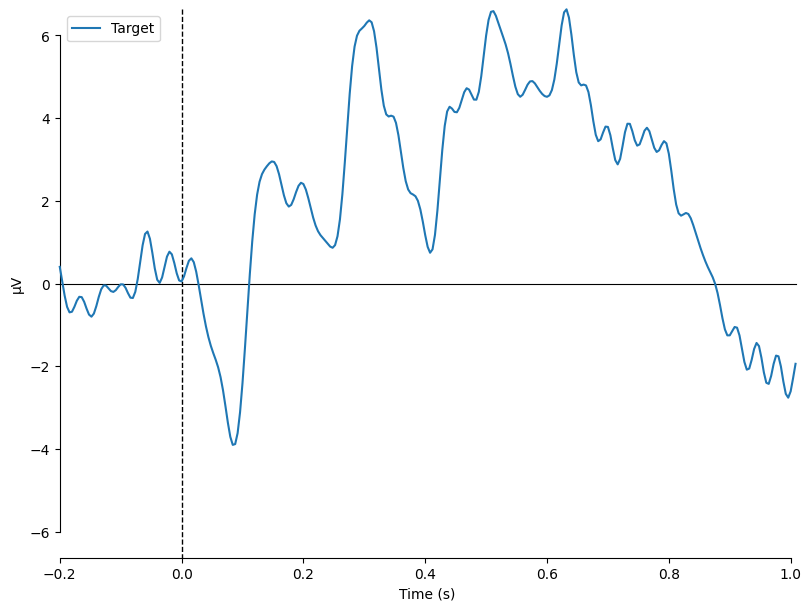

[<Figure size 800x600 with 1 Axes>]

In [30]:
mne.viz.plot_compare_evokeds(
    {"Target": epochs['target'].average()},
    combine='mean',
    show=True
)

In [31]:
# Interesting epochs:
# 1. Everything with response
# 2. For each brand (facebook_idx, youtube_idx):
# 2.1. Facebook words (facebook_words_idx)
# 2.2. Youtube words (youtube_words_idx)
# 2.3. Shared words (shared_words_idx)
# 2.4. Unrelated words (unrelated_words_idx)
filt_fb_idx = np.intersect1d(response_idx, facebook_idx)
filt_yt_idx = np.intersect1d(response_idx, youtube_idx)
fb_fb_words_idx = np.intersect1d(filt_fb_idx, facebook_words_idx)
fb_yt_words_idx = np.intersect1d(filt_fb_idx, youtube_words_idx)
fb_sh_words_idx = np.intersect1d(filt_fb_idx, shared_words_idx)
fb_un_words_idx = np.intersect1d(filt_fb_idx, unrelated_words_idx)
yt_fb_words_idx = np.intersect1d(filt_yt_idx, facebook_words_idx)
yt_yt_words_idx = np.intersect1d(filt_yt_idx, youtube_words_idx)
yt_sh_words_idx = np.intersect1d(filt_yt_idx, shared_words_idx)
yt_un_words_idx = np.intersect1d(filt_yt_idx, unrelated_words_idx)
fb_facebook = epochs[fb_fb_words_idx]
fb_youtube = epochs[fb_yt_words_idx]
fb_shared = epochs[fb_sh_words_idx]
fb_unrelated = epochs[fb_un_words_idx]
yt_facebook = epochs[yt_fb_words_idx]
yt_youtube = epochs[yt_yt_words_idx]
yt_shared = epochs[yt_sh_words_idx]
yt_unrelated = epochs[yt_un_words_idx]

In [151]:
unrelated = np.intersect1d(response_idx, unrelated_words_idx)
related_idx = np.union1d(fb_yt_words_idx, fb_sh_words_idx)
related = np.intersect1d(response_idx, related_idx)
related_unrelated = np.concatenate((related, unrelated))
related_unrelated

array([  0,   7,   8,  11,  12,  14,  33,  36,  37,  39,  42,  53,  68,
        75,  78,  82,  99, 100, 107, 110, 114, 120, 122, 129, 131, 155,
       157, 159, 161, 168, 171, 174, 179, 181, 185, 186, 193, 204, 205,
       224, 225, 227, 230, 232, 237, 247, 248, 259, 263, 265, 268, 269,
       272, 278, 279, 285, 286, 290, 291, 292, 296, 304, 306, 310, 313,
       315, 316, 330, 334, 335, 337, 340, 342, 344, 358, 363, 370, 375,
       389, 396, 398, 399,   6,   9,  17,  18,  19,  24,  29,  40,  49,
        50,  51,  59,  63,  67,  71,  80,  81,  86,  92,  93,  95, 108,
       113, 117, 119, 127, 132, 133, 134, 136, 140, 149, 152, 166, 167,
       173, 178, 180, 188, 190, 192, 194, 196, 199, 207, 209, 211, 215,
       219, 221, 223, 226, 228, 235, 238, 239, 240, 243, 252, 254, 255,
       257, 261, 266, 270, 271, 282, 287, 288, 293, 294, 297, 309, 311,
       321, 323, 324, 326, 329, 338, 341, 350, 360, 362, 364, 366, 367,
       368, 372, 374, 377, 383, 390, 392, 394, 395])

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


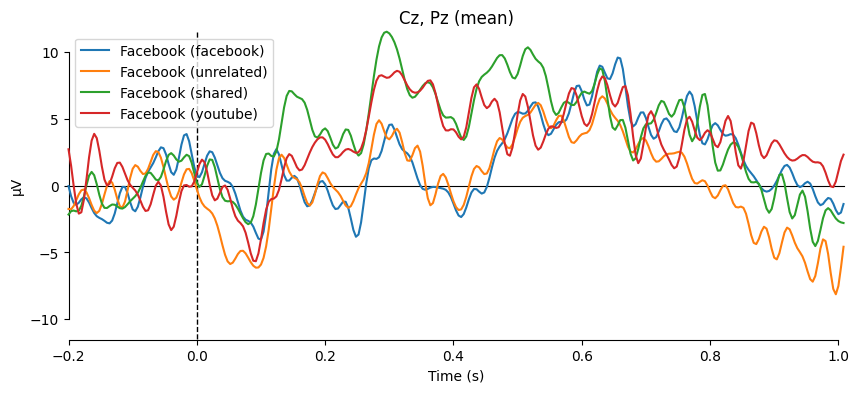

[<Figure size 1000x400 with 1 Axes>]

In [34]:
fig, ax = plt.subplots(figsize=(10, 4))
mne.viz.plot_compare_evokeds(
    {"Facebook (facebook)": fb_facebook.average(), "Facebook (unrelated)": fb_unrelated.average(),
    "Facebook (shared)": fb_shared.average(), "Facebook (youtube)": fb_youtube.average()},
    picks=picks,
    combine='mean',
    show=True,
    axes=ax
)

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


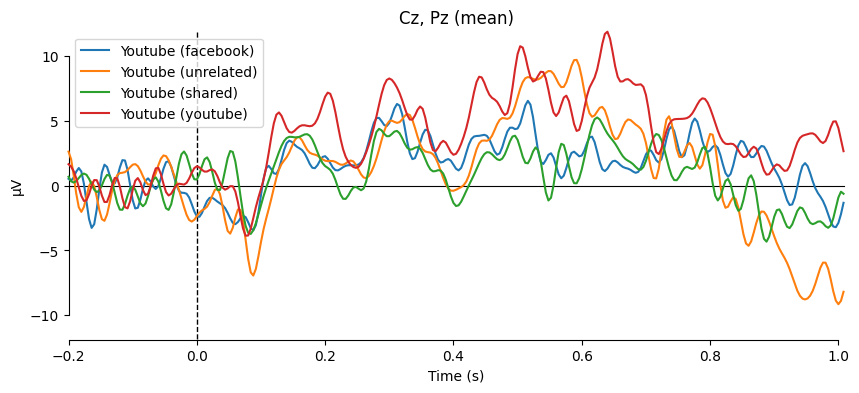

[<Figure size 1000x400 with 1 Axes>]

In [150]:
fig, ax = plt.subplots(figsize=(10, 4))
mne.viz.plot_compare_evokeds(
    {"Youtube (facebook)": yt_facebook.average(), "Youtube (unrelated)": yt_unrelated.average(),
    "Youtube (shared)": yt_shared.average(), "Youtube (youtube)": yt_youtube.average()},
    picks=picks,
    combine='mean',
    show=True,
    axes=ax
)

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


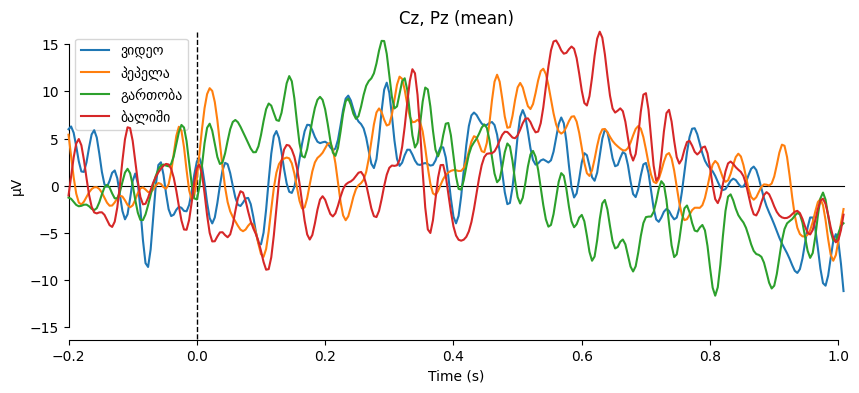

[<Figure size 1000x400 with 1 Axes>]

In [36]:
# Let's do each word's N400:
word_idx = np.intersect1d(response_idx, csv_data[csv_data['target'] == 'ვიდეო'].index.values)
word2_idx = np.intersect1d(response_idx, csv_data[csv_data['target'] == 'პეპელა'].index.values)
word3_idx = np.intersect1d(response_idx, csv_data[csv_data['target'] == 'გართობა'].index.values)
word4_idx = np.intersect1d(response_idx, csv_data[csv_data['target'] == 'ბალიში'].index.values)
fig, ax = plt.subplots(figsize=(10, 4))
mne.viz.plot_compare_evokeds(
    {"ვიდეო": epochs[word_idx].average(), "პეპელა": epochs[word2_idx].average(),
    "გართობა": epochs[word3_idx].average(), "ბალიში": epochs[word4_idx].average()},
    picks=picks,
    combine='mean',
    show=True,
    axes=ax
)

In [152]:
import numpy as np
import mne
from sklearn.preprocessing import StandardScaler

# --------------------------------------------------------
# 0. Assume you already have:
#    - epochs: MNE Epochs, shape (n_trials, n_channels, n_times)
#    - epochs.metadata["category"] with values like "Television", "Relaxation", "Price", "Unrelated"
#    - epochs.metadata["subject"] with subject IDs
# --------------------------------------------------------

# 1) Select unrelated trials to build the N400 template
unrel_epochs = epochs[unrelated]
if len(unrel_epochs) < 30:
    raise ValueError("Not enough unrelated trials to build a template.")

# 2) Compute the average ERP of unrelated trials
unrel_evoked = unrel_epochs.average()  # shape (n_channels, n_times)
data = unrel_evoked.data  # numpy array

In [153]:
# 3) Define N400 time window (adjust to your data!)
# typical N400: 300–500 ms
tmin_n400, tmax_n400 = 0.3, 0.5
tmask = (unrel_evoked.times >= tmin_n400) & (unrel_evoked.times <= tmax_n400)

# 4) Build temporal template = average over channels in N400 window
temporal_template = data.mean(axis=0)[tmask]  # shape (n_times_in_window,)
# normalize to avoid scaling issues
temporal_template = temporal_template / np.linalg.norm(temporal_template)

# 5) Build spatial template = average over time in N400 window
spatial_template = data[:, tmask].mean(axis=1)  # shape (n_channels,)
spatial_template = spatial_template / np.linalg.norm(spatial_template)

In [249]:
np.dot(trial_win, temporal_template)

np.float64(3.349921890228353e-05)

In [163]:
# (This gives us separate spatial and temporal “shapes” of the N400)

# --------------------------------------------------------
# 6) Now compute a single-trial N400 “score” for every NON-unrelated trial
#    We'll do a simple separable projection:
#    score = (spatial dot trial * temporal dot trial_window)
#    which mimics “how much this trial looks like the N400 template”.
# --------------------------------------------------------
# select trials we want to score
epochs_keep = epochs

n_trials = len(epochs_keep)
n400_scores = []

for ep in epochs_keep:  # ep: (n_channels, n_times)
    ep_data = ep
    # project spatially
    spatial_proj = np.dot(spatial_template, ep_data)  # shape (n_times,)
    # take N400 window
    trial_win = spatial_proj[tmask]
    # project temporally
    n400_val = np.dot(trial_win, temporal_template)   # scalar
    n400_scores.append(n400_val)

n400_scores = np.array(n400_scores)
n400_scores

array([-2.57004659e-05,  3.77690334e-05,  1.29794754e-05,  9.78620171e-05,
        2.49025885e-05,  4.94411780e-05,  6.84017154e-05,  6.65238092e-05,
       -2.62546106e-05,  3.01363057e-05,  1.45303585e-05,  5.95808656e-05,
        4.49936310e-05,  4.74105423e-05,  9.22160852e-05,  3.73122701e-05,
        5.93242802e-06,  2.09089579e-05,  1.78526524e-05, -4.45496492e-05,
        4.21343082e-05,  8.42054170e-05,  1.67744026e-05,  5.22420024e-07,
       -1.06568494e-05,  8.70017645e-05, -1.89219607e-04,  8.98394788e-05,
        7.15718648e-05,  1.30164621e-04, -1.92394673e-06, -1.00589279e-04,
        1.54592998e-05,  9.49866707e-05,  7.14467235e-05,  5.84487366e-05,
        1.19111989e-04,  5.13701070e-05, -1.36475855e-05,  5.43157455e-05,
        3.64571982e-05, -1.14277083e-04,  1.89171100e-04,  1.61930838e-05,
       -9.33509190e-05,  1.06925621e-05, -2.68882252e-05,  1.42017654e-04,
        7.80263380e-05, -9.32341715e-05, -1.13250602e-04, -2.34744762e-05,
        1.57023630e-04, -

In [164]:
# --------------------------------------------------------
# 7) Z-score per subject
# --------------------------------------------------------
n400_z = np.zeros_like(n400_scores, dtype=float)

# z-score
mean_ = n400_scores.mean()
std_ = n400_scores.std(ddof=1)
if std_ == 0:
    # fallback: no variance
    n400_z = 0.0
else:
    n400_z = (n400_scores - mean_) / std_

print(n400_z)

[-8.26261825e-01 -1.29428464e-02 -3.30604372e-01  7.57108353e-01
 -1.77817690e-01  1.36627842e-01  3.79594386e-01  3.55530280e-01
 -8.33362817e-01 -1.10751122e-01 -3.10730847e-01  2.66561125e-01
  7.96355164e-02  1.10606611e-01  6.84759531e-01 -1.87959607e-02
 -4.20907548e-01 -2.28993383e-01 -2.68157883e-01 -1.06780144e+00
  4.29952167e-02  5.82108202e-01 -2.81974931e-01 -4.90233165e-01
 -6.33487989e-01  6.17941515e-01 -2.92164972e+00  6.54304917e-01
  4.20217720e-01  1.17104451e+00 -5.21581711e-01 -1.78591163e+00
 -2.98827089e-01  7.20262722e-01  4.18614118e-01  2.52053652e-01
  1.02941246e+00  1.61345772e-01 -6.71812263e-01  1.99092148e-01
 -2.97531330e-02 -1.96131164e+00  1.92717289e+00 -2.89424141e-01
 -1.69315692e+00 -3.59909629e-01 -8.41482161e-01  1.32293317e+00
  5.02927456e-01 -1.69166088e+00 -1.94815798e+00 -7.97737262e-01
  1.51522466e+00 -1.68915479e+00 -7.82118837e-01  1.23667691e+00
 -2.96684728e-01 -3.27105660e-01 -3.97126907e-01 -3.59246900e-01
 -1.52771804e+00  6.48674

In [165]:
# related_n400_z = n400_scores[:len(related)]
# unrelated_n400_z = n400_scores[len(related):]
# print(len(n400_scores), len(n400_scores))

In [225]:
# plt.boxplot([related_n400_z, unrelated_n400_z])
# plt.hist(unrelated_n400_z, bins=20, edgecolor='black')
# plt.title('Related vs Unrelated')
# plt.grid(axis='y', alpha=0.75)
# plt.show()

In [239]:
csv_data['score'] = n400_scores[1:]
csv_data['zscore'] = n400_z[1:]
# Build a translation table (Unicode codepoint → replacement string)
GE_TO_LAT = {
    ord('ა'): 'a',  ord('ბ'): 'b',   ord('გ'): 'g',   ord('დ'): 'd',
    ord('ე'): 'e',  ord('ვ'): 'v',   ord('ზ'): 'z',   ord('თ'): 't',
    ord('ი'): 'i',  ord('კ'): 'k',   ord('ლ'): 'l',   ord('მ'): 'm',
    ord('ნ'): 'n',  ord('ო'): 'o',   ord('პ'): 'p',   ord('ჟ'): 'zh',
    ord('რ'): 'r',  ord('ს'): 's',   ord('ტ'): "t'",  ord('უ'): 'u',
    ord('ფ'): "p'", ord('ქ'): "k'",  ord('ღ'): 'gh',  ord('ყ'): "q'",
    ord('შ'): 'sh', ord('ჩ'): 'ch',  ord('ც'): 'ts',  ord('ძ'): 'dz',
    ord('წ'): "ts'",ord('ჭ'): "ch'", ord('ხ'): 'kh',  ord('ჯ'): 'j',
    ord('ჰ'): 'h',
    # Rare/obsolete (map to nearest)
    ord('ჱ'): 'e',  ord('ჲ'): 'i',   ord('ჳ'): 'ui',  ord('ჴ'): 'kh',
    ord('ჵ'): 'o',  ord('ჶ'): 'f',   ord('ჷ'): 'y',   ord('ჸ'): 'h',
}

def georgian_to_latin_series(s: pd.Series) -> pd.Series:
    return s.astype(str).str.translate(GE_TO_LAT)

csv_data['target_latin'] = georgian_to_latin_series(csv_data['target'])
pdata = csv_data.groupby(['brand', 'target_latin'])[['score', 'zscore']].mean()

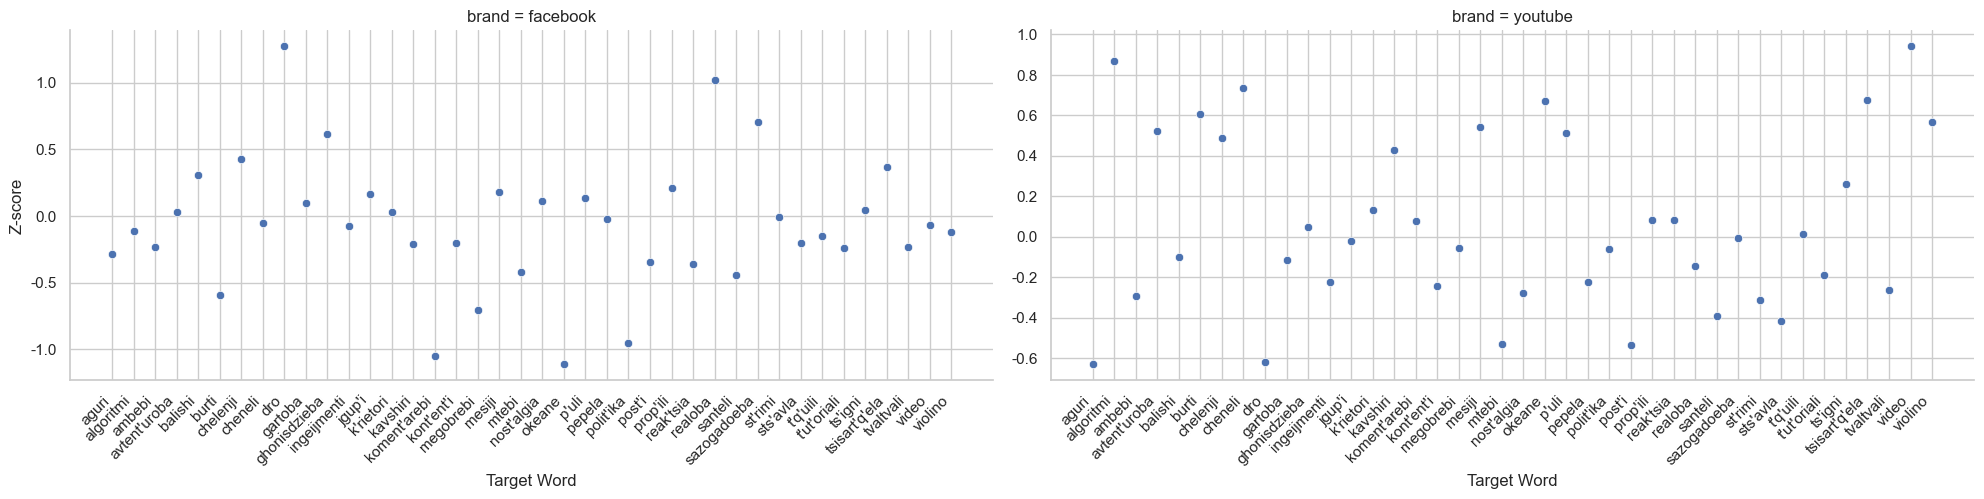

In [240]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming pdata was created as described
# Reset index so 'brand' and 'target' become columns
pdata_reset = pdata.reset_index()

# Set plot style
sns.set(style="whitegrid")

# Alternative plot using zscore instead
g = sns.FacetGrid(pdata_reset, col="brand", height=5, sharey=False, aspect=2)
g.map_dataframe(sns.scatterplot, x="target_latin", y="zscore")
g.set_xticklabels(rotation=45, ha='right')
g.set_axis_labels("Target Word", "Z-score")
plt.subplots_adjust(hspace=0.3, bottom=0.25, top=0.95)
# plt.tight_layout()

In [243]:
csv_data['score'] = n400_scores[:-1]
csv_data['zscore'] = n400_z[:-1]
# Build a translation table (Unicode codepoint → replacement string)
GE_TO_LAT = {
    ord('ა'): 'a',  ord('ბ'): 'b',   ord('გ'): 'g',   ord('დ'): 'd',
    ord('ე'): 'e',  ord('ვ'): 'v',   ord('ზ'): 'z',   ord('თ'): 't',
    ord('ი'): 'i',  ord('კ'): 'k',   ord('ლ'): 'l',   ord('მ'): 'm',
    ord('ნ'): 'n',  ord('ო'): 'o',   ord('პ'): 'p',   ord('ჟ'): 'zh',
    ord('რ'): 'r',  ord('ს'): 's',   ord('ტ'): "t'",  ord('უ'): 'u',
    ord('ფ'): "p'", ord('ქ'): "k'",  ord('ღ'): 'gh',  ord('ყ'): "q'",
    ord('შ'): 'sh', ord('ჩ'): 'ch',  ord('ც'): 'ts',  ord('ძ'): 'dz',
    ord('წ'): "ts'",ord('ჭ'): "ch'", ord('ხ'): 'kh',  ord('ჯ'): 'j',
    ord('ჰ'): 'h',
    # Rare/obsolete (map to nearest)
    ord('ჱ'): 'e',  ord('ჲ'): 'i',   ord('ჳ'): 'ui',  ord('ჴ'): 'kh',
    ord('ჵ'): 'o',  ord('ჶ'): 'f',   ord('ჷ'): 'y',   ord('ჸ'): 'h',
}

def georgian_to_latin_series(s: pd.Series) -> pd.Series:
    return s.astype(str).str.translate(GE_TO_LAT)

csv_data['target_latin'] = georgian_to_latin_series(csv_data['target'])
pdata = csv_data.groupby(['brand', 'target_latin'])[['score', 'zscore']].mean()

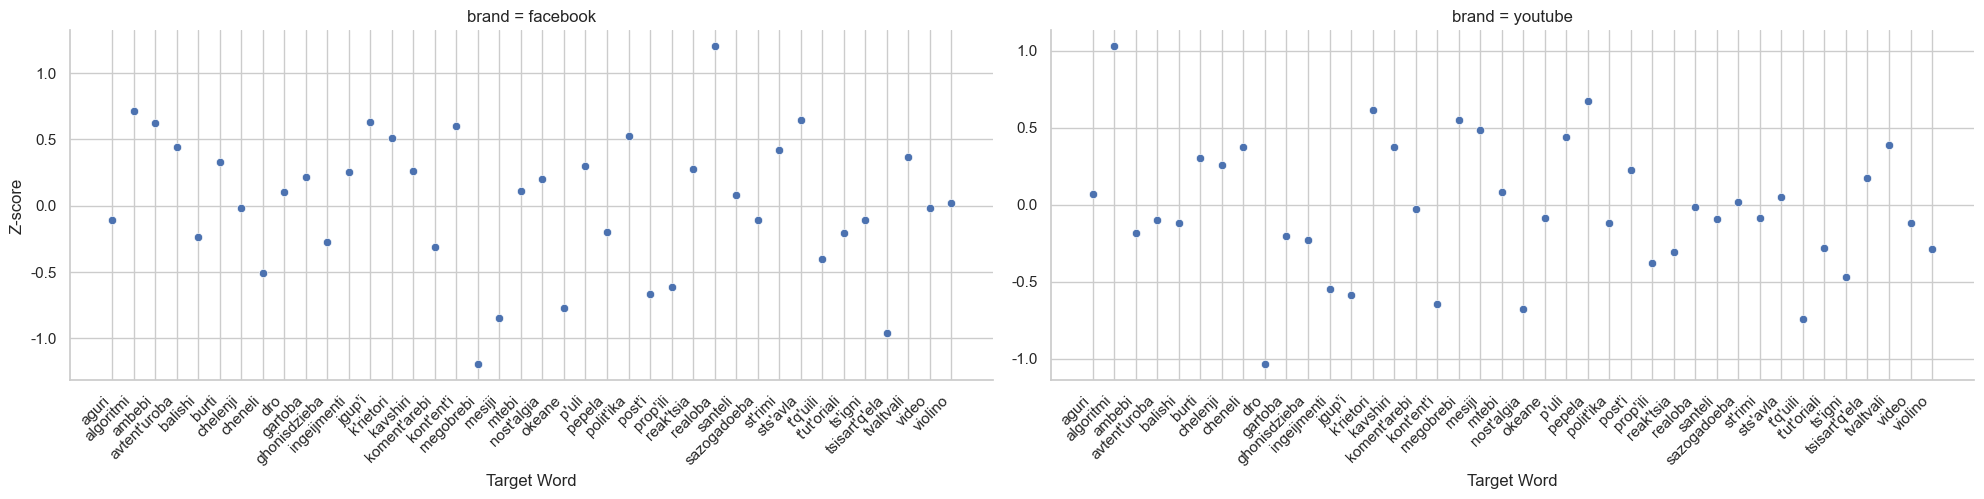

In [242]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming pdata was created as described
# Reset index so 'brand' and 'target' become columns
pdata_reset = pdata.reset_index()

# Set plot style
sns.set(style="whitegrid")

# Alternative plot using zscore instead
g = sns.FacetGrid(pdata_reset, col="brand", height=5, sharey=False, aspect=2)
g.map_dataframe(sns.scatterplot, x="target_latin", y="zscore")
g.set_xticklabels(rotation=45, ha='right')
g.set_axis_labels("Target Word", "Z-score")
plt.subplots_adjust(hspace=0.3, bottom=0.25, top=0.95)
# plt.tight_layout()